# ML Homework3
0756021 張逸群

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Random Data Generator

### a. Univariate gaussian data generator

In [2]:
def sample_from_uni_normal(mean, var, size=1):
    # using Marsaglia polar method
    U, V = np.random.uniform(-1, 1, size), np.random.uniform(-1, 1, size)
    S = U*U + V*V
    
    # replace S >= 1
    while (S >= 1).any():
        replace_indices = (S >= 1)
        replace_size = replace_indices.sum()
        U[replace_indices], V[replace_indices] = np.random.uniform(-1, 1, replace_size), np.random.uniform(-1, 1, replace_size)
        S[replace_indices] = U[replace_indices]*U[replace_indices] + V[replace_indices]*V[replace_indices]
    
    X = U * np.sqrt( -2. * np.log(S) / S )
    return X * np.sqrt(var) + mean

In [3]:
def normal_generator(mean, var, cache_size=100):
    while True:
        data = sample_from_uni_normal(mean, var, size=cache_size)
        for d in data:
            yield d

#### Result

1.0031565967136715 2.0095954840088646


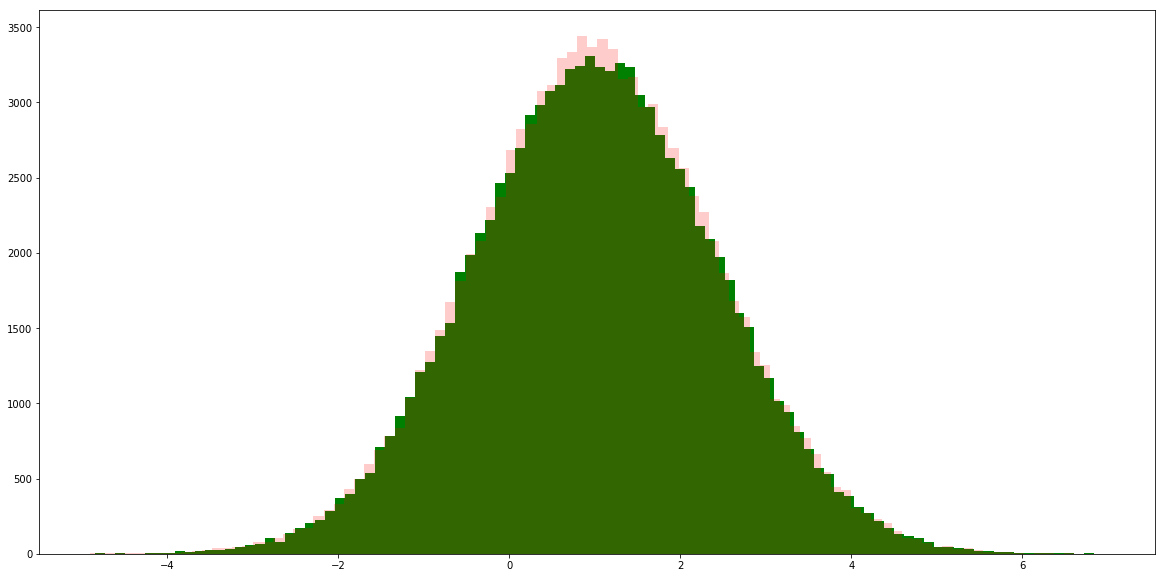

In [4]:
plt.figure(figsize=(20, 10))
X = sample_from_uni_normal(1, 2, 100000)
np_X = np.random.normal(1, np.sqrt(2), 100000) # numpy use std instead of var

_ = plt.hist(X, bins=100, color='green')
_ = plt.hist(np_X, bins=100, color='red', alpha=0.2)

print(X.mean(), X.var())

### b. Polynomial basis linear model data generator

In [5]:
def sample_from_poly_linear_model(weights, var, size=1, return_X=False):
    weights = np.array(weights)
    
    def phi(X):
        phi = np.ndarray((weights.shape[0], X.shape[0]))
        for i in range(weights.shape[0]):
            phi[i, :] = np.power(X, i)
        return phi
            
    X = np.random.uniform(-1., 1., size)
    e = sample_from_uni_normal(0, var, size)
    y = weights @ phi(X) + e
    if return_X:
        return X, y
    return y

In [6]:
def spl_generator(weights, var, return_X=False, cache_size=100):
    while True:
        data = sample_from_poly_linear_model(weights, var, size=cache_size, return_X=return_X)
        if return_X:
            X, y = data
            for xi, yi in zip(X, y):
                yield xi, yi
        else:
            for d in data:
                yield d

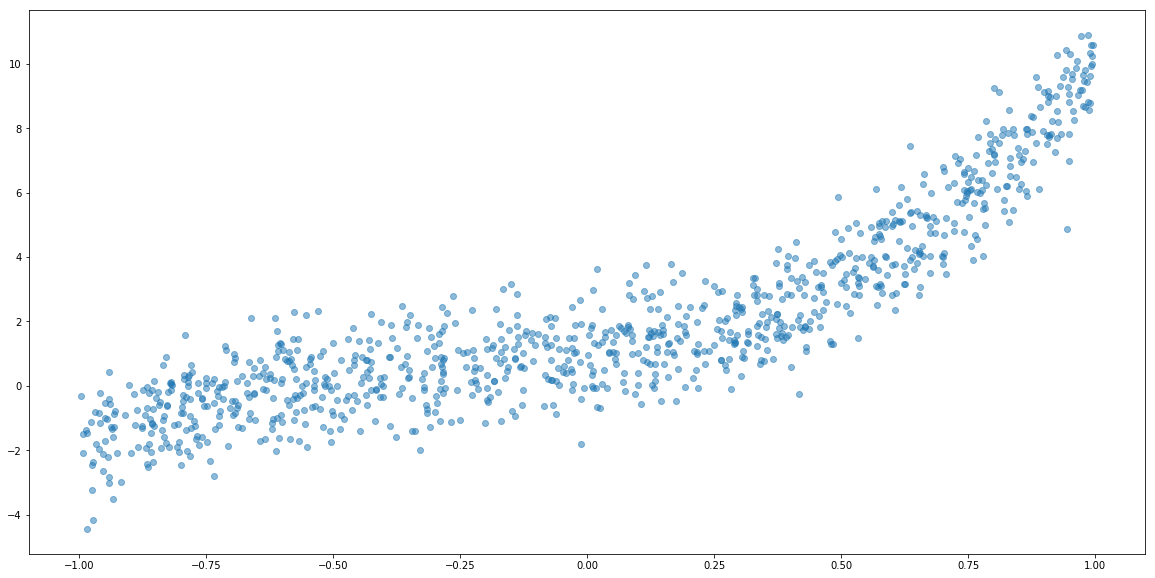

In [7]:
plt.figure(figsize=(20, 10))
X, y = sample_from_poly_linear_model([1, 2, 3, 4], 1, 1000, return_X=True)
plt.scatter(X, y, alpha=0.5)
plt.show()

## 2. Sequential Estimator

In [8]:
def sequential_estimator(data_generator, max_iter=None, max_delta=None, verbose=False):
    if max_iter is None and max_delta is None:
        raise('Either max_iter / max_delta must not be None!')
    
    # naive algorithm
    history = list()
    n_data = 0
    sum_data = 0.
    sum_square_data = 0.
    last_estimate = [0, 0]
    while True:
        if max_iter is not None and n_data >= max_iter:
            break
        
        data_new = next(data_generator)
        n_data += 1
        sum_data += data_new
        sum_square_data += data_new * data_new
        
        estimate_mean = sum_data / n_data
        estimate_var = (sum_square_data - sum_data*sum_data/n_data)/(n_data-1 + 1e-9)
        if max_delta is not None and\
            abs(last_estimate[0] - estimate_mean) < max_delta and\
            abs(last_estimate[1] - estimate_var) < max_delta:
            break
        last_estimate = [estimate_mean, estimate_var]
        history.append(last_estimate)
        
        if verbose:
            print('Add data point:', data_new)
            print('Mean =', estimate_mean, '\tVariance =', estimate_var)
    return np.array(history)

In [9]:
history = sequential_estimator(normal_generator(5., 2.), max_delta=0.001, verbose=False)

In [10]:
print('Final Estimate - mean:', history[-1, 0], 'variance:', history[-1, 1])

Final Estimate - mean: 5.011460856851305 variance: 2.076522813366994


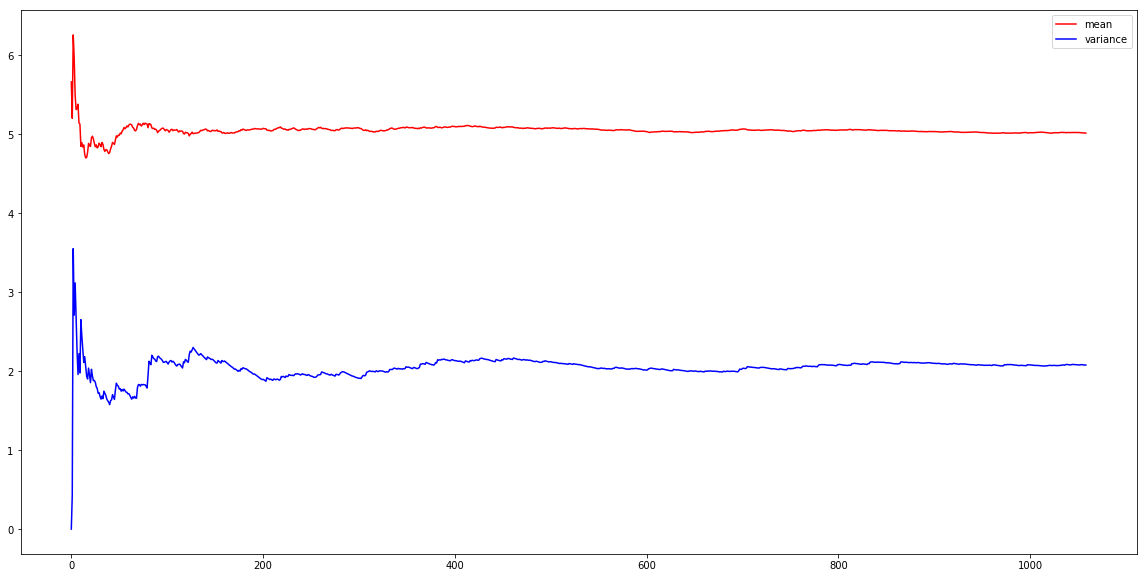

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(history[:, 0], color='r', label='mean') # mean
plt.plot(history[:, 1], color='b', label='variance') # variance
plt.legend()

## 3. Baysian Linear Regression

In [12]:
def phi(X, basis_dim):
    X = np.array(X).reshape(-1)
    phi = np.ndarray((basis_dim, X.shape[0]))
    for i in range(basis_dim):
        phi[i, :] = np.power(X, i)
    return phi

def predict(weights, X):
    weights = np.array(weights).reshape(-1, 1)
    return (weights.T @ phi(X, weights.shape[0])).flatten()

def predictive_distribution(mu, precision, X, gt_var):
    means = mu.T @ phi(X, mu.shape[0])
    variances = list()
    for phi_xi in phi(X, mu.shape[0]).T:
        variances.append(gt_var + phi_xi @ np.linalg.inv(precision) @ phi_xi.T)
    return means.flatten(), np.array(variances)

def plot_predictive_distribution(gt_weights, gt_var, posteriors, data, ylim=None):
    def plot_posterior(ax, p, n_data, title=None):
        means, variances = predictive_distribution(p['mean'], p['precision'], X, gt_var)
        ax.plot(X, predict(p['mean'], X), color='black')
        ax.plot(X, means+variances, color='r')
        ax.plot(X, means-variances, color='r')
        ax.scatter(data['X'][:n_data], data['y'][:n_data])
        ax.set_title(title)
        
    X = np.arange(-2, 2, 0.05)
    
    f, axes = plt.subplots(2, 2, figsize=(20, 10))
    
    # plot ground truth
    gt_y = predict(gt_weights, X)
    axes[0, 0].plot(X, gt_y, color='black')
    axes[0, 0].plot(X, gt_y+gt_var, color='red')
    axes[0, 0].plot(X, gt_y-gt_var, color='red')
    axes[0, 0].set_title('Ground Truth')
    
    # plot predict result
    plot_posterior(axes[0, 1], posteriors['final'], -1, 'Predict result')
    plot_posterior(axes[1, 0], posteriors['10'], 10, 'After 10 incomes')
    plot_posterior(axes[1, 1], posteriors['50'], 50, 'After 50 incomes')
    
    # set all ylim
    for ax in axes.flatten():
        if ylim is not None:
            ax.set_ylim(*ylim)
        else:
            ax.set_ylim(-20, 25)

In [13]:
def baysian_linear_regression(data_generator, basis_dim, initial_a, prior_b, max_iter=None, max_delta=None, verbose=False):
    def verbose_function(posterior, X, y):
        print('Add data point ({:.5}, {:.5}):\n'.format(X, y.flatten()[0]))
        print('Postirior mean:')
        for i in range(basis_dim): print('\t{: .10f}'.format(posterior['mean'][i][0]))
        print()
        print('Posterior variance:')
        var = np.linalg.inv(posterior['precision'])
        for i in range(basis_dim):
            print(('\t{: .10f},'*basis_dim)[:-1].format(*var[i]))
        
        print()
        means, variances = predictive_distribution(posterior['mean'], posterior['precision'], X, initial_a)
        print('Predictive distribution ~ N({:.5f}, {:.5f})'.format(means[0], variances[0]))
        print('--------------------------------------------------')
    
    if max_iter is None and max_delta is None:
        raise('Either max_iter / max_delta must not be None!')
    
    prior = { 'mean': np.zeros((basis_dim, 1)), 
                'precision': prior_b * np.identity(basis_dim)}
    rtn_posteriors, rtn_data = dict(), {'X': list(), 'y': list()}
    last_prior = None
    n_iter = 0
    while True:
        if max_iter is not None and n_iter >= max_iter:
            break
            
        n_iter += 1
        
        # new data point
        X, y = next(data_generator)
        rtn_data['X'].append(X)
        rtn_data['y'].append(y)
        
        design_matrix = np.array([np.power(X, i) for i in range(basis_dim)]).reshape(1, basis_dim)
        y = np.array([y]).reshape(1, 1)
        
        last_prior = copy.deepcopy(prior)
        prior['precision'] = initial_a * design_matrix.T @ design_matrix + last_prior['precision']
        prior['mean'] = np.linalg.inv(prior['precision']) @ (initial_a * design_matrix.T @ y + last_prior['precision'] @ last_prior['mean'])
        if n_iter == 10:
            rtn_posteriors['10'] = copy.deepcopy(prior)
        elif n_iter == 50:
            rtn_posteriors['50'] = copy.deepcopy(prior)
        
        if max_delta is not None and\
            (np.absolute(prior['mean'] - last_prior['mean']) < max_delta).all():
            break
            
        if verbose:
            if n_iter < 5:
                verbose_function(prior, X, y)
    if verbose:
        print('\n...\n')
        verbose_function(prior, X, y)
    
    rtn_posteriors['final'] = copy.deepcopy(prior)
    rtn_data['X'] = np.array(rtn_data['X'])
    rtn_data['y'] = np.array(rtn_data['y'])
    return rtn_posteriors, rtn_data

Add data point (-0.19458, 0.53498):

Postirior mean:
	 0.2623301697
	-0.0510443259
	 0.0099322286
	-0.0019326176

Posterior variance:
	 0.5096475204,	 0.0954130125,	-0.0185655081,	 0.0036124852
	 0.0954130125,	 0.9814344919,	 0.0036124852,	-0.0007029190
	-0.0185655081,	 0.0036124852,	 0.9992970810,	 0.0001367743
	 0.0036124852,	-0.0007029190,	 0.0001367743,	 0.9999733864

Predictive distribution ~ N(0.27265, 1.50965)
--------------------------------------------------
Add data point (-0.81629, -1.8269):

Postirior mean:
	-0.0665821495
	 0.5028331628
	-0.4977240459
	 0.4232677917

Posterior variance:
	 0.4454460020,	 0.2035262503,	-0.1176566693,	 0.0866088046
	 0.2035262503,	 0.7993753681,	 0.1704787298,	-0.1404659813
	-0.1176566693,	 0.1704787298,	 0.8463558660,	 0.1282365743
	 0.0866088046,	-0.1404659813,	 0.1282365743,	 0.8926801446

Predictive distribution ~ N(-1.03891, 1.63155)
--------------------------------------------------
Add data point (0.82597, 7.5235):

Postirior mean:
	 1.

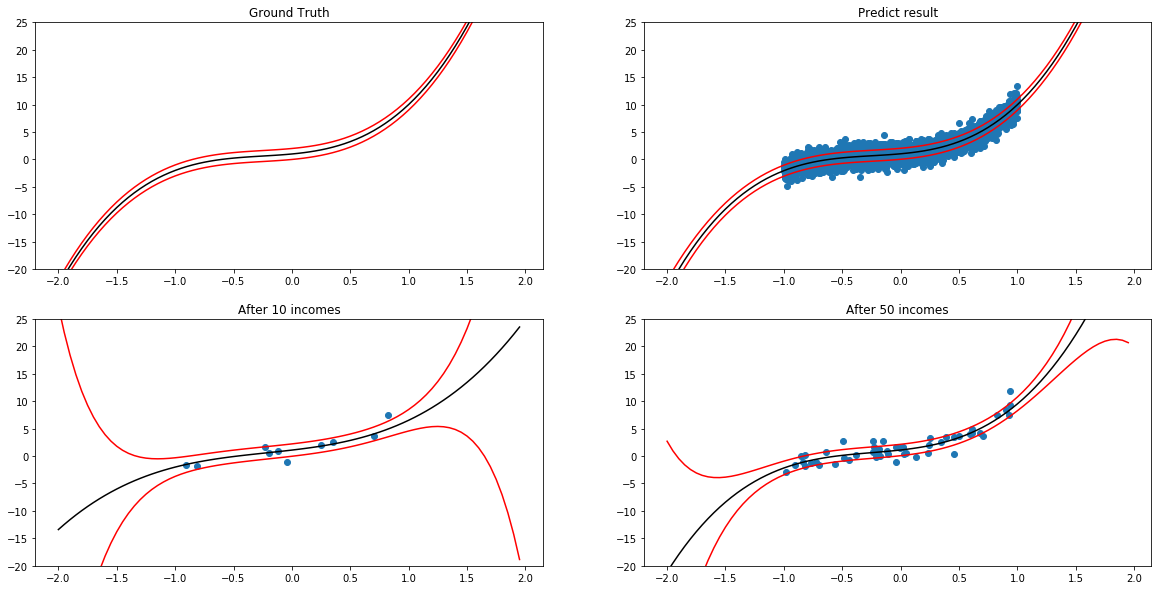

In [14]:
# parameters
b = 1
n = 4
a = 1
w = [1, 2, 3, 4]
dg = spl_generator(w, a, return_X=True, cache_size=100)

posteriors, data = baysian_linear_regression(data_generator=dg, basis_dim=n, initial_a=a, prior_b=b, max_delta=1e-6, verbose=True)
plot_predictive_distribution(w, a, posteriors, data)

Add data point (0.14923, 0.32109):

Postirior mean:
	 0.0031784096
	 0.0004743131
	 0.0000707816
	 0.0000105627

Posterior variance:
	 0.0099010124,	-0.0000147719,	-0.0000022044,	-0.0000003290
	-0.0000147719,	 0.0099977956,	-0.0000003290,	-0.0000000491
	-0.0000022044,	-0.0000003290,	 0.0099999509,	-0.0000000073
	-0.0000003290,	-0.0000000491,	-0.0000000073,	 0.0099999989

Predictive distribution ~ N(0.00325, 1.01012)
--------------------------------------------------
Add data point (-0.52903, 2.6661):

Postirior mean:
	 0.0292086540
	-0.0134599092
	 0.0074179932
	-0.0038799650

Posterior variance:
	 0.0098041672,	 0.0000370702,	-0.0000295396,	 0.0000141457
	 0.0000370702,	 0.0099700440,	 0.0000143038,	-0.0000077975
	-0.0000295396,	 0.0000143038,	 0.0099922354,	 0.0000040782
	 0.0000141457,	-0.0000077975,	 0.0000040782,	 0.0099978355

Predictive distribution ~ N(0.03898, 1.01353)
--------------------------------------------------
Add data point (0.58465, 3.2893):

Postirior mean:
	 0.060

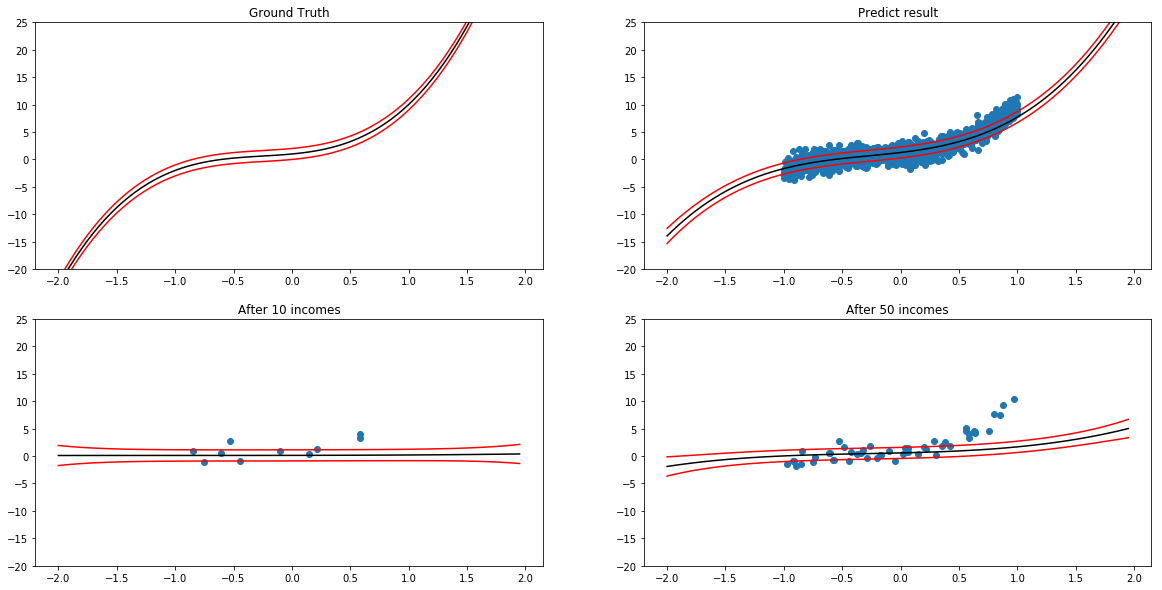

In [15]:
# parameters
b = 100
n = 4
a = 1
w = [1, 2, 3, 4]
dg = spl_generator(w, a, return_X=True, cache_size=100)

posteriors, data = baysian_linear_regression(data_generator=dg, basis_dim=n, initial_a=a, prior_b=b, max_delta=1e-6, verbose=True)
plot_predictive_distribution(w, a, posteriors, data)

Add data point (-0.22878, -0.28928):

Postirior mean:
	-0.2083525208
	 0.0476667862
	-0.0109051837

Posterior variance:
	 0.2797531506,	 0.1647777165,	-0.0376977642
	 0.1647777165,	 0.9623022358,	 0.0086244758
	-0.0376977642,	 0.0086244758,	 0.9980268967

Predictive distribution ~ N(-0.21983, 3.25331)
--------------------------------------------------
Add data point (0.033283, 1.107):

Postirior mean:
	 0.3911152707
	 0.4613631841
	-0.0872169380

Posterior variance:
	 0.1496228516,	 0.0749739995,	-0.0211322847
	 0.0749739995,	 0.9003281402,	 0.0200564147
	-0.0211322847,	 0.0200564147,	 0.9959181249

Predictive distribution ~ N(0.40637, 3.15557)
--------------------------------------------------
Add data point (-0.084471, -0.37108):

Postirior mean:
	 0.1740204699
	 0.4627800197
	-0.0633744041

Posterior variance:
	 0.1066188955,	 0.0752546581,	-0.0164093559
	 0.0752546581,	 0.9003263085,	 0.0200255912
	-0.0164093559,	 0.0200255912,	 0.9953994271

Predictive distribution ~ N(0.13448, 3.

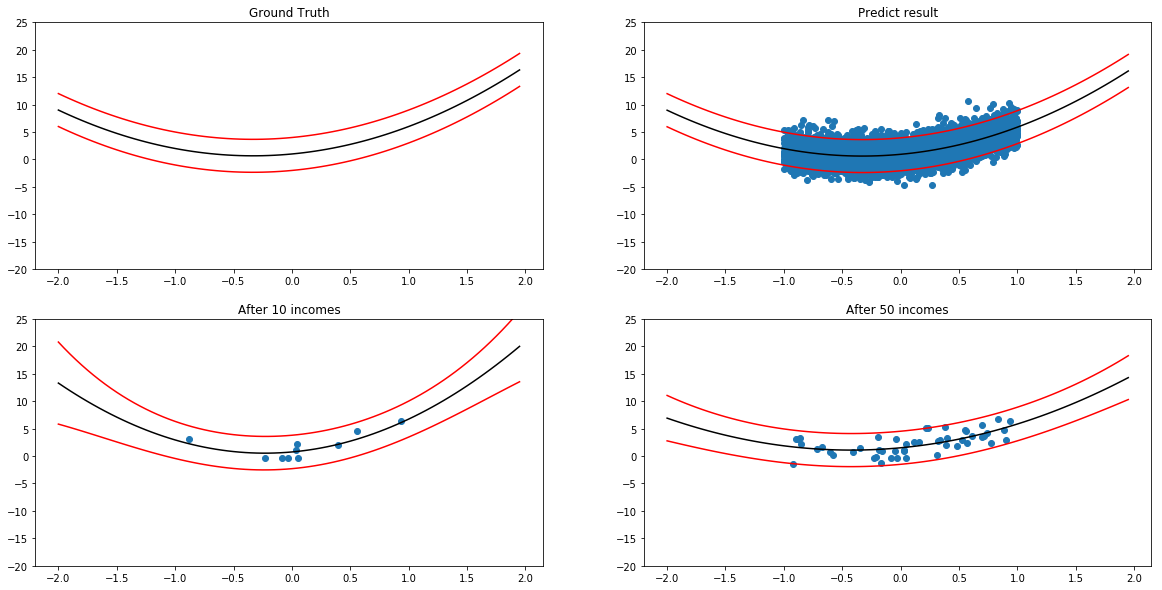

In [16]:
# parameters
b = 1
n = 3
a = 3
w = [1, 2, 3]
dg = spl_generator(w, a, return_X=True, cache_size=100)

posteriors, data = baysian_linear_regression(data_generator=dg, basis_dim=n, initial_a=a, prior_b=b, max_delta=1e-6, verbose=True)
plot_predictive_distribution(w, a, posteriors, data)